In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, binom, poisson, norm

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['text.usetex'] = True


1. Consider a bioassay experiment giving rise to data of the form

$(x_i,n_i,y_i) : i = 1,...,k ,$

where $x_i$ represents the $i$th of $k$ dose levels, given to $n_i$ animals, of which $y_i$ died. In this particular experiment, twenty animals were tested, five at each of four dose levels, with the following results.

In [2]:
column_data = {
    'dose': [-0.86, -0.30, -0.05, 0.73],
    'n_animals': [5, 5, 5, 5],
    'n_deaths': [0, 1, 3, 5]
}

df = pd.DataFrame(column_data)
raw_data = df.values
df

,dose,n_animals,n_deaths
0,-0.86,5,0
1,-0.30,5,1
2,-0.05,5,3
3,0.73,5,5


An appropriate statistical model for these data is

$y_i|\theta \sim indep\ Binomial(n_i, \theta_i)$

where $\theta_i$ is the probability of death for animals given dose $x_i$, with a dose-response relation given by

$log\bigg(\cfrac{\theta_i}{1 - \theta_i}\bigg) = \alpha + \beta x_i$, 

that is, the logistic regression model.

For a prior distribution on the model parameters $\alpha$ and $\beta$, we will take $\alpha \sim Normal(0, 22)$,
and $\beta \sim Normal(10, 102)$, with $corr(\alpha, \beta) = 0.50$.

### (a) 

Compute the joint posterior density $p(\alpha, \beta\ |\ y, n, x)$ at a grid of points $(\alpha, \beta)$, over a range that captures almost all the mass of the posterior distribution. Plot the contours corresponding to $0.001, 0.01$ and $0.05, 0.15, . . . , 0.95$ times the density at the mode.

In [3]:
def logistic(x):
    return 1 / (1. + (np.exp(-x)))

def compute_likelihood(data, alpha, beta, use_log=False):
    likelihoods = np.empty(data.shape[0])
    
    if use_log:
        for i, (dose, n, deaths) in enumerate(data):
            p_star = logistic(alpha + beta * dose)
            likelihood = np.log(binom.pmf(deaths, n, p_star))
            likelihoods[i] = likelihood
        return likelihoods.sum()
    
    for i, (dose, n, deaths) in enumerate(data):
        p_star = logistic(alpha + beta * dose)
        likelihood = binom.pmf(deaths, n, p_star)
        likelihoods[i] = likelihood
    
    return np.prod(likelihoods)

In [4]:
# set up the prior
a_mean = 0
a_var = 2**2
b_mean = 10
b_var = 10**2

cov = .7 * np.sqrt(a_var) * np.sqrt(b_var)
cov_matrix = np.matrix([[a_var, cov],
                        [cov, b_var]])
# sample the prior
prior_samples = np.random.multivariate_normal([a_mean, b_mean], cov_matrix, 1000)

# define the domain
a_range = np.linspace(-8, 8, 100)
b_range = np.linspace(-35, 45, 100)

# generate the likelihood, prior, and posterior grids
prior_grid = np.empty((a_range.shape[0], b_range.shape[0]))
llh_grid = np.empty((a_range.shape[0], b_range.shape[0]))
posterior_grid = np.empty((a_range.shape[0], b_range.shape[0]))
for i, a_i in enumerate(a_range):
    for j, b_i in enumerate(b_range):
        prior = multivariate_normal.pdf([a_i, b_i], [a_mean, b_mean], cov_matrix, 1)
        likelihood = compute_likelihood(raw_data, a_i, b_i)
        prior_grid[j, i] = prior
        llh_grid[j, i] = likelihood

# scale the likelihood, prior, and posterior grids
llh_grid = llh_grid / llh_grid.max()
prior_grid = prior_grid / prior_grid.max()

# create the posterior grid
posterior_grid = llh_grid * prior_grid
posterior_grid = posterior_grid / posterior_grid.max()
posterior_grid.shape

(100, 100)

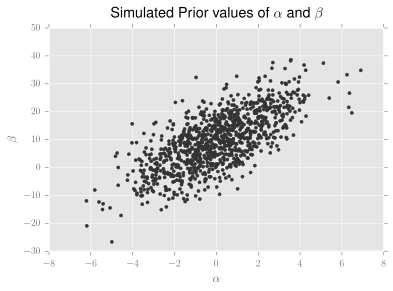

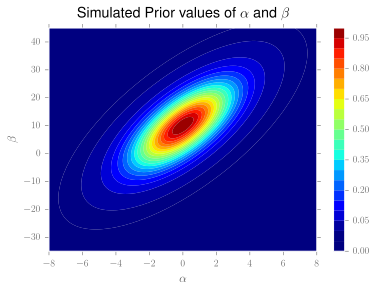

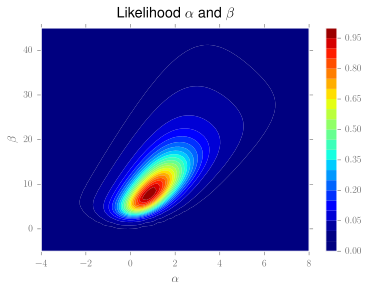

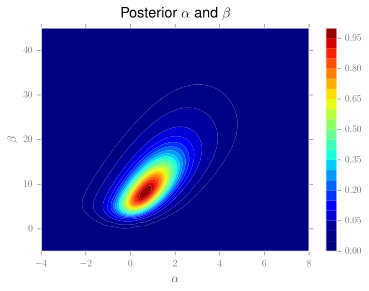

In [7]:
# plot the simulated prior values
plt.rcParams['figure.figsize'] = 6, 4
plt.scatter(prior_samples[:,0], prior_samples[:,1], color='#333333', s=10)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.title(r'Simulated Prior values of $\alpha$ and $\beta$', y=1.025)
plt.show()

levels = [0, .001, .01] + [.05 * i for i in range(1, 21)]

# plot the prior level curves data
plt.contourf(a_range, b_range, prior_grid, levels=levels)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.colorbar()
plt.title(r'Simulated Prior values of $\alpha$ and $\beta$', y=1.025)
plt.show()

# plot the likelihood level curves
plt.contourf(a_range, b_range, llh_grid, levels=levels)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.xlim(-4, 8)
plt.ylim(-5, 45)
plt.title(r'Likelihood $\alpha$ and $\beta$', y=1.025)
plt.colorbar()
plt.show()

# plot the posterior level curves
plt.contourf(a_range, b_range, posterior_grid, levels=levels)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.xlim(-4, 8)
plt.ylim(-5, 45)
plt.title(r'Posterior $\alpha$ and $\beta$', y=1.025)
plt.colorbar()
# plt.savefig('plots/p_1_a.pdf', format='pdf')
plt.show()

### (b)
Simulate 1000 random samples $(\alpha^s,\beta^s)$ from the posterior distribution, and display them on a scatterplot with the same scale as your contour plot.

In [8]:
def sample_posterior(n, no_beta_lt_0=False):
    prob_grid = posterior_grid / posterior_grid.sum()   # normalized
    a_prob_marg = prob_grid.sum(axis=0)

    # we need the index to get the marginal for each beta
    a_samples_ind = np.random.choice(list(range(a_range.shape[0])), n, replace=True, p=a_prob_marg)
    a_samples = a_range[a_samples_ind]

    b_samples = np.empty_like(a_samples)
    
    for i, sample_ind in enumerate(a_samples_ind):
        probs = posterior_grid[sample_ind] / posterior_grid[sample_ind].sum()
        b_star = np.random.choice(b_range, 1, replace=True, p=probs)
        if no_beta_lt_0:
            while b_star < 0:
                b_star = np.random.choice(b_range, 1, replace=True, p=probs)
        b_samples[i] = b_star
        
    return np.c_[a_samples, b_samples]

# sample the posterior
data = sample_posterior(1000, no_beta_lt_0=True)
alpha_sim = data[:,0] + np.random.normal(0, .03, data.shape[0])
beta_sim = data[:,1] + np.random.normal(0, .1, data.shape[0])

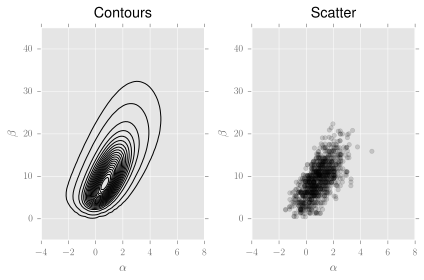

In [9]:
# plot the posterior level curves
levels = [0, .001, .01] + [.05 * i for i in range(1, 21)]

plt.subplot(1, 2, 1)
plt.contour(a_range, b_range, posterior_grid, levels=levels, colors='black')
plt.xlim(-4, 8)
plt.ylim(-5, 45)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.title('Contours', y=1.025)

plt.subplot(1, 2, 2)
plt.scatter(alpha_sim, beta_sim, color='black', alpha=.15)
plt.xlim(-4, 8)
plt.ylim(-5, 45)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.title('Scatter', y=1.025)
plt.tight_layout()
# plt.savefig('plots/p_1_b.pdf', format='pdf', dpi=400)
plt.show()

### (c)
A parameter of interest in bioassay studies is the LD50—the dose level at which the probability of death is $50\%$. In a logistic regression with $x = log(dose)$, we have LD50 $= e^{−\alpha/\beta}$. Simulate 1000 random samples from the posterior distribution of the LD50, conditional on $\beta > 0$. Plot a histogram your samples and give an approximate $95\%$ posterior interval for the LD50.

95% predictive interval: [0.711, 1.204]


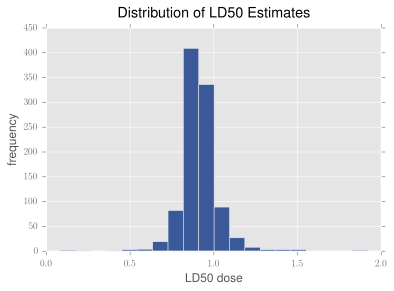

In [15]:
# sample values of LD50
data = sample_posterior(1000, no_beta_lt_0=True)
LD50 = np.exp(-1. * (data[:,0] / data[:,1]))

# print the 95% posterior predictive interval
lower, upper = np.percentile(LD50, [2.5, 97.5])
print('95% predictive interval: [{:.3f}, {:.3f}]'.format(lower, upper))

# plot it
plt.hist(LD50[LD50 < 2], bins=20, color='#3b5998')
plt.xlabel('LD50 dose')
plt.ylabel('frequency')
plt.title('Distribution of LD50 Estimates', y=1.025)
# plt.savefig('plots/p_1_3.pdf', format='pdf')
plt.show()

# 2.

Consider again the plane crashes data from Problem 5 of Homework 1. Here we will assume the number of fatal accidents in year $1975 + t$ follows a Poisson distribution with mean $\theta_t$, where $log \theta_t = \alpha + \beta t$. Assume the noninformative prior $p(\alpha, \beta) \propto 1$.

In [16]:
df = pd.read_csv('data/accident_data.csv')
df

,year,accidents,exposures
0,1976,24,3864
1,1977,25,4300
2,1978,31,5026
3,1979,31,5482
4,1980,22,5815
5,1981,21,6034
6,1982,26,5876
7,1983,20,6224
8,1984,16,7434
9,1985,22,7106


### (c)

Plot the contours and take 1000 draws from the joint posterior density of $(\alpha,\beta)$. Prepare an adjacent display of your contour plot and scatterplot. Make sure both plots are on the same scale.

In [17]:
def compute_likelihood(data, alpha, beta):
    likelihoods = np.empty(data.shape[0])
    
    for i, (year, accidents) in enumerate(data):
        theta_star = np.exp(alpha + beta * year)
        likelihood = poisson.pmf(accidents, theta_star)
        likelihoods[i] = likelihood
    return np.prod(likelihoods)

In [20]:
data = np.array([df.year - 1975, df.accidents]).T

# define the domain
a_range = np.linspace(2.8, 3.9, 100)
b_range = np.linspace(-.15, .05, 100)

# generate the joint posterior (also the likelihood)
llh_grid = np.empty((a_range.shape[0], b_range.shape[0]))
for i, a_i in enumerate(a_range):
    for j, b_i in enumerate(b_range):
        likelihood = compute_likelihood(data, a_i, b_i)
        llh_grid[j, i] = likelihood

# scale the likelihood grid
llh_grid = llh_grid / llh_grid.max()

In [22]:
def sample_posterior_crashes(n, no_beta_lt_0=False):
    prob_grid = llh_grid / llh_grid.sum()   # normalized
    a_prob_marg = prob_grid.sum(axis=0)

    # we need the index to get the marginal for each beta
    a_samples_ind = np.random.choice(list(range(a_range.shape[0])), n, replace=True, p=a_prob_marg)
    a_samples = a_range[a_samples_ind]

    b_samples = np.empty_like(a_samples)
    
    for i, sample_ind in enumerate(a_samples_ind):
        probs = llh_grid[sample_ind] / llh_grid[sample_ind].sum()
        b_star = np.random.choice(b_range, 1, replace=True, p=probs)
        if no_beta_lt_0:
            while b_star < 0:
                b_star = np.random.choice(b_range, 1, replace=True, p=probs)
        b_samples[i] = b_star
        
    return np.c_[a_samples, b_samples]

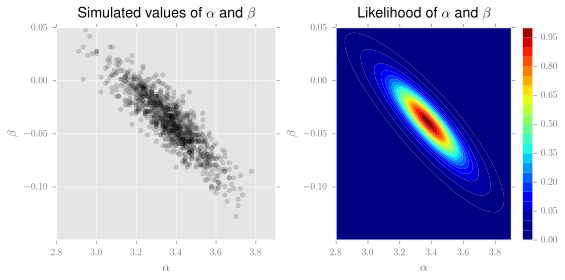

In [24]:
data_sim = sample_posterior_crashes(1000, no_beta_lt_0=False)

levels = [0, .001, .01] + [.05 * i for i in range(1, 21)]

# plot the prior level curves data
plt.rcParams['figure.figsize'] = 8, 4
plt.subplot(1, 2, 1)
plt.scatter(data_sim[:,0], data_sim[:,1], color='black', alpha=.15)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.xlim([2.8, 3.9])
plt.ylim([-.15, .05])
plt.title(r'Simulated values of $\alpha$ and $\beta$', y=1.025)

plt.subplot(1, 2, 2)
plt.contourf(a_range, b_range, llh_grid, levels=levels)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.colorbar()
plt.title(r'Likelihood of $\alpha$ and $\beta$', y=1.025)

plt.tight_layout()
# plt.savefig('plots/p_2_c.pdf', format='pdf')
plt.show()

(d) Display a histogram summarizing the approximate posterior density for the <em>expected</em> number of fatal accidents in 1986, and give a 95% posterior interval for this quantity.

95% predictive interval: [13.09, 26.96]


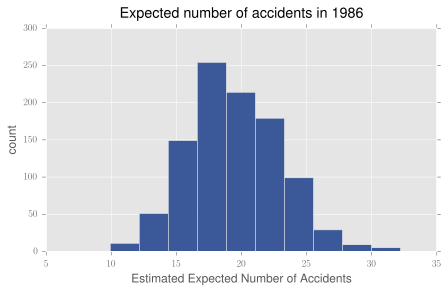

In [27]:
theta_sim = np.exp(data_sim[:,0] + data_sim[:,1] * 11) # exp(a + b*x)

# print the 95% posterior predictive interval
lower, upper = np.percentile(theta_sim, [2.5, 97.5])
print('95% predictive interval: [{:.2f}, {:.2f}]'.format(lower, upper))

# plot it
plt.rcParams['figure.figsize'] = 7, 4
plt.hist(theta_sim, color='#3b5998')
plt.xlabel(r'Estimated Expected Number of Accidents')
plt.ylabel('count')
plt.title(r'Expected number of accidents in 1986', y=1.025)
plt.savefig('plots/p_2_d.pdf', format='pdf')
plt.show()

(e) Display a histogram summarizing the approximate predictive distribution for the number of fatal accidents in 1986, and give an approximate 95% prediction interval.

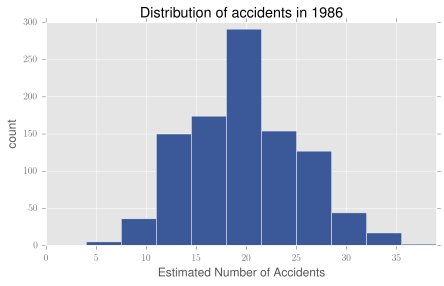

95% predictive interval: [10.0, 30.0]


In [30]:
theta_sim = np.exp(data_sim[:,0] + data_sim[:,1] * 11) # exp(a + b*x)
y_sim = np.random.poisson(theta_sim)

plt.rcParams['figure.figsize'] = 7, 4
plt.hist(y_sim, color='#3b5998')
plt.xlim((0, y_sim.max()))
plt.xlabel('Estimated Number of Accidents', y=1.025)
plt.ylabel('count')
plt.title('Distribution of accidents in 1986')
# plt.savefig('plots/p_2_e.pdf', format='pdf')
plt.show()

lower, upper = np.percentile(y_sim, [2.5, 97.5])
print('95% predictive interval: [{}, {}]'.format(lower, upper))

# 3.

Suppose $y_1,..., y_5$ are independent samples from a Cauchy distribution with unknown center $\theta$ and known scale 1: $p(y_i|\theta) \propto \frac{1}{(1 + (y_i - \theta)^2)}$. Assume a noninformative prior $p(\theta) \propto \frac{1}{\theta}$. Given the observations $(y_1,..., y_5) = (-2, -1, 0, 1.5, 2.5)$

In [31]:
y_p3 = np.array([-2., -1., 0, 1.5, 2.5])


### (b)
Compute the unnormalized posterior density function, $p(\theta)p(y|\theta)$, on a grid of points $\theta$, over a range that captures almost all the mass of the posterior distribution. Using the grid approximation, compute and plot the <em>normalized</em> posterior density function, $p(\theta|y)$, as a function of $\theta$.

In [32]:
theta_grid = np.linspace(0, 5, 1000)  + .0000001

prior_grid = np.power(theta_grid, -1)
prior_grid = prior_grid / prior_grid.sum()   # normalize it

llh_grid = np.zeros_like(theta_grid)
post_grid = np.zeros_like(theta_grid)

def cauchy_llh(data, theta):
    
    def _cauchy(data_i, theta_):
        return np.prod(1. / (1 + (data_i - theta_)**2))
    
    return np.prod([_cauchy(data_i, theta) for data_i in data])
    
# generate the likelihood
for i, theta_star in enumerate(theta_grid):
    llh_grid[i] = cauchy_llh(y_p3, theta_star)

# generate the posterior, fine grained because the valid range is so small
for i, theta_star in enumerate(theta_grid):
    llh = cauchy_llh(y_p3, theta_star)
    llh_grid[i] = llh
    
llh_grid = llh_grid / llh_grid.sum()

post_grid = llh_grid * prior_grid
post_grid = post_grid / post_grid.sum()

prior_grid.sum()

1.0000000000000002

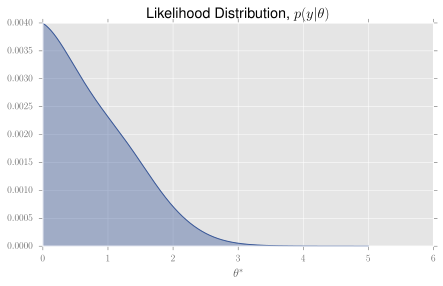

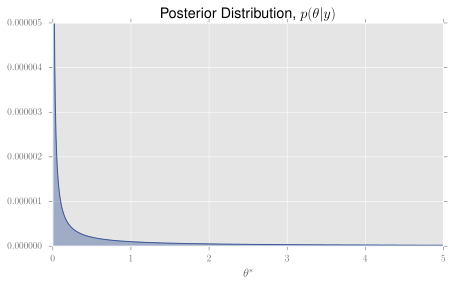

In [35]:
plt.plot(theta_grid, llh_grid, color='#3b5998')
plt.fill_between(theta_grid, 0, llh_grid, color='#3b5998', alpha=.4)
plt.xlabel(r'$\theta^*$')
plt.title(r'Likelihood Distribution, $p(y | \theta)$')
plt.show()

plt.plot(theta_grid, prior_grid, color='#3b5998')
plt.fill_between(theta_grid, 0, prior_grid, color='#3b5998', alpha=.4)
plt.ylim((0, .000005))
plt.xlim((0, 5))
plt.xlabel(r'$\theta^*$')
plt.title(r'Posterior Distribution,  $p(\theta | y)$')
plt.savefig('plots/p_3_b.pdf', format='pdf')
plt.show()

### (d) 

Find the posterior mode of $\theta$ using Newton’s method, that is, given an initial guess $\hat{\theta_0}$ , construct a sequence of successively better approximations by

<center>$\hat{\theta}_{t+1} = \hat{\theta}_t - \dfrac{\frac{d}{d\theta} log p( \theta| y)|_{\theta = \hat{\theta}_t}}{\frac{d^2}{d\theta^2} log p( \theta| y)|_{\theta = \hat{\theta}_t}}$<center>

terminating when $|\hat{\theta}_{t+1} - \hat{\theta}_t| \approx 0$.

In [38]:
def first_deriv(y, theta):
    n = y.shape[0]
    prior_ddt = -1. * (1 / theta)
    def _first_deriv(y_i, theta_):
        sse = y_i - theta
        return prior_ddt + (2 * sse / (1 + sse**2))
    
    return prior_ddt -  sum([_first_deriv(y_i, theta) for y_i in y])

def second_deriv(y, theta):
    n = y.shape[0]
    prior_d2dt = 1 / theta**2
    def _second_deriv(y_i, theta):
        sse = y_i - theta
        return prior_d2dt + ((sse**2 - 1) / (1 + sse**2)**2)
    
    return prior_d2dt +  2 * sum([_second_deriv(y_i, theta) for y_i in y])
    
def newtons_method(n_iters, init_point=.5, verbose=False):
    theta_star = init_point
    for i in range(n_iters):
        first_d = first_deriv(y_p3, theta_star)
        second_d = second_deriv(y_p3, theta_star)
        new_theta_star =  theta_star - (first_d / second_d)
        
        delta = theta_star - new_theta_star
        if verbose:
            print('iteration {}\ndelta={}\ntheta*= {}\n'\
                  .format(i+1, delta, theta_star))
        theta_star = new_theta_star
    return theta_star

newtons_method(10, verbose=True)

iteration 1
delta=0.19701353553557865
theta*= 0.5

iteration 2
delta=0.11517740492626083
theta*= 0.30298646446442135

iteration 3
delta=0.06984255370679471
theta*= 0.18780905953816052

iteration 4
delta=0.04338458155985424
theta*= 0.11796650583136581

iteration 5
delta=0.02728081317852732
theta*= 0.07458192427151157

iteration 6
delta=0.017255462334297623
theta*= 0.04730111109298425

iteration 7
delta=0.010945448221895401
theta*= 0.03004564875868663

iteration 8
delta=0.006952871918152316
theta*= 0.019100200536791227

iteration 9
delta=0.004420015035390987
theta*= 0.012147328618638912

iteration 10
delta=0.002811024217640669
theta*= 0.007727313583247924



0.0049162893656072553